In [1]:
from aniaft import coord
from aniaft import Segment, Line, Bezier
from aniaft import Boundary, DirectedSeg
from aniaft import Metric, UniformMetric
from aniaft import Triangulation

import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', size=16)
plt.rc('figure', figsize=(6, 6))

In [3]:
# Declare V-points (corner points)
vpts = []
vpts.append(coord(0, 0)) # 0
vpts.append(coord(0, 2)) # 1
vpts.append(coord(5, 2)) # 2
vpts.append(coord(5, 0)) # 3
vpts.append(coord(0, 5)) # 4
vpts.append(coord(5, 5)) # 5
vpts.append(coord(3, 4)) # 6

In [4]:
x = np.array([v.x for v in vpts])
y = np.array([v.y for v in vpts])

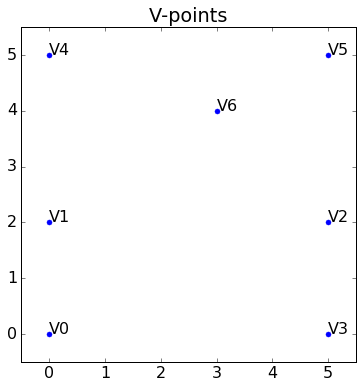

In [5]:
plt.plot(x, y, '.', markersize=10)
plt.axis([-0.5, 5.5, -0.5, 5.5])
for i,xy in enumerate(zip(x,y)):
    plt.annotate(s='V' + str(i), xy=xy)
plt.title('V-points');

In [6]:
import numpy as np



class Wave(Segment):
    def __init__(self, v1, v2, vpts):
        super().__init__(v1, v2, label=2, tmin=0, tmax=5)
        
        # Sanity check
        def dist(v, w): return np.linalg.norm([v.x - w.x,  v.y - w.y])
        def rep(v): return '(' + str(v.x) + ', ' + str(v.y) + ')'
        
        assert dist(self(self.tmin), vpts[v1]) < 1e-10, \
            'Curve does not pass through V-point ' + rep(vpts[v1]) + \
            ' at tmin xy = ' + rep(self(self.tmin))
        assert dist(self(self.tmax), vpts[v2]) < 1e-10, \
            'Curve does not pass through V-point ' + rep(vpts[v2]) + \
            ' at tmin xy = ' + rep(self(self.tmax))            

    def __call__(self, t):
        return coord(t, 2 + np.sin(np.pi * t))

In [7]:
# Join corner points via segments (may be curved)

seg = []
seg.append(Line(0, 1, vpts))
seg.append(Wave(1, 2, vpts))
seg.append(Line(2, 3, vpts))
seg.append(Line(3, 0, vpts))
seg.append(Line(1, 4, vpts))
seg.append(Line(4, 5, vpts))
seg.append(Line(5, 2, vpts))
seg.append(Bezier(6, 6, vpts, coord(2.5, 3.5), coord(3.5, 3.5)))

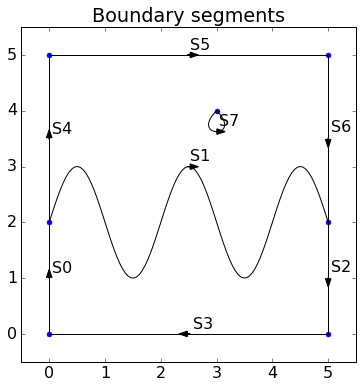

In [8]:
def coord2vec(c): return [c.x, c.y]

xy = np.array([coord2vec(v) for v in vpts])
plt.plot(xy.T[0], xy.T[1], '.b', markersize=10)

for i,s in enumerate(seg):
    ts = np.linspace(s.tmin, s.tmax, 100)
    xy = np.array([coord2vec(s(t)) for t in ts])
    ab = s(ts[49])
    ae = s(ts[50])
    plt.plot(xy.T[0], xy.T[1], 'k')
    plt.arrow(ab.x, ab.y, ae.x - ab.x, ae.y - ab.y, head_width=.1, color='k')
    plt.annotate(s='S' + str(i), xy=(ab.x+0.05, ab.y+0.1))
plt.axis([-0.5, 5.5, -0.5, 5.5])
plt.title('Boundary segments');

In [9]:
# Declare regions by their boundary segments. Direction is important.
# A region should be on the right of its segments. If segment is reversed, supply True as
# second argument to DirectedSegment.

# Note that segment S1 is reversed for domain 1 and S7 is reversed for domain 2

def forw(i): return DirectedSeg(i, False)
def back(i): return DirectedSeg(i, True)

reg = [ \
    [forw(0), forw(1), forw(2), forw(3)], \
    [forw(4), forw(5), forw(6), back(1), forw(7)], \
    [back(7)]
]

In [10]:
bnd = Boundary(vpts, seg, reg)

In [11]:
class WeirdMetric(Metric):
    def size(self, p):
        # Refine near (3, 3.7)
        return 0.08 / (1 + 0.5 / (0.1 + np.linalg.norm([p.x - 3, p.y - 3.7])))
    
metric = WeirdMetric()
tr = Triangulation(bnd, metric)
tr.generate()

0

In [12]:
p = tr.points()
t = tr.triangles()
e = tr.edges()

x = np.array([v.x for v in p])
y = np.array([v.y for v in p])
l = np.array([v.label for v in t])
t = np.array([[v.v1, v.v2, v.v3] for v in t])
e = np.array([(v.v1, v.v2) for v in e])

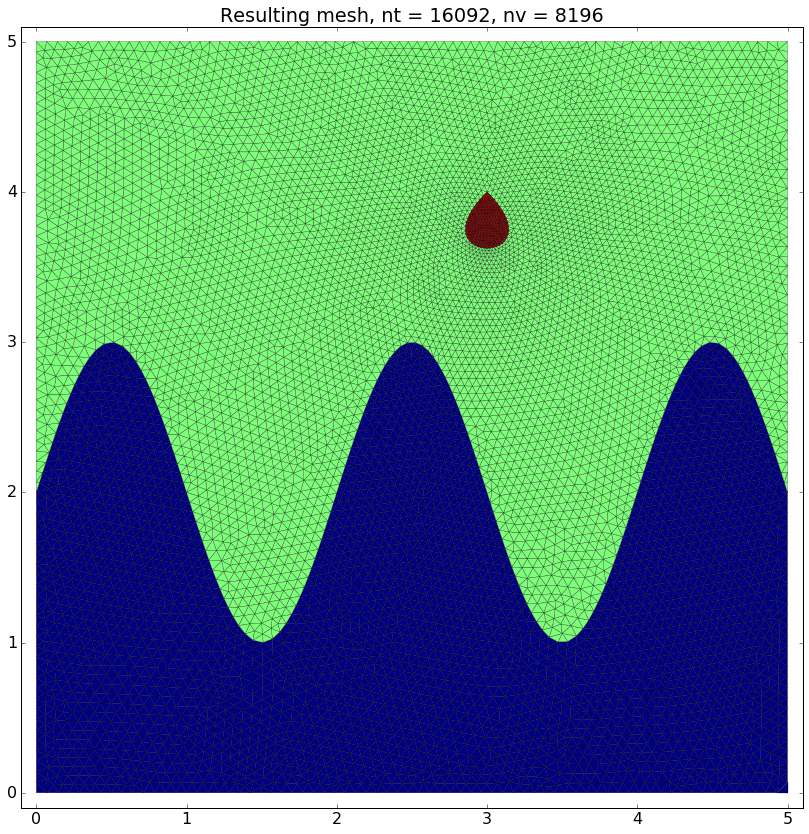

In [13]:
plt.figure(figsize=(14,14))

plt.tripcolor(x, y, t, facecolors=l, edgecolors='k')
plt.axis([-0.1, 5.1, -0.1, 5.1]);
plt.title('Resulting mesh, nt = ' + str(len(t)) + ', nv = ' + str(len(x)));